
# Multi-Agent System for LeetCode Problem Solving

### Architecture Overview:

**ReAct Pattern Integration**: The workflow follows the ReAct (Reason-Act-Observe) pattern where an LLM-based agent analyzes the current state, decides which tool/node to invoke next, executes it, and continues based on results.

### Components:

1. **ReAct Node** (LLM) - Orchestrates workflow by analyzing state and deciding next action (call parser / plan approaches / proceed to execution)
2. **Parser Node** (with retry) - Fetches problem description from LeetCode API with exponential backoff
3. **Multi-Planner Node** (LLM) - Generates 2-3 different algorithmic approaches for solving the problem
4. **Parallel Executor Node** (async) - Generates solutions for all approaches concurrently using `asyncio.gather()`
5. **Analyzer Node** (LLM) - Compares all solutions and recommends the best approach based on quality metrics
6. **Finalizer Node** - Creates comprehensive report with all solutions, test results, and comparison analysis

### Key Features:

 **ReAct Pattern**: LLM-driven decision making at each workflow step (reason → act → observe loop) \
 **Structured Output**: All LLM responses use Pydantic models for type safety \
 **Retry Logic**: Parser retries with exponential backoff on failure \
 **Async/Await**: Full async workflow using `ainvoke` and `asyncio.gather()` for true parallelism \
 **Role Separation**: Distinct LLM calls with specialized system prompts (react / planner / generator / analyzer) \
 **Universal Test Parser**: Dynamic parsing of LeetCode examples using regex + `ast.literal_eval`

### Tools:

- `leetcode_parser` - Fetches and parses problem description from LeetCode GraphQL API
- `code_executor` - Executes Python code in isolated subprocess with timeout protection

## Installation

```bash
pip install langchain langgraph langchain-openai pydantic requests beautifulsoup4 python-dotenv

Install dependencies:

pip install langchain langgraph langchain-openai pydantic requests beautifulsoup4 python-dotenv



In [103]:
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Verify required variables are set
required_vars = ['UNIVERSITY_API_BASE', 'UNIVERSITY_API_KEY']
missing_vars = [var for var in required_vars if not os.getenv(var)]

if missing_vars:
    raise ValueError(f"Missing environment variables: {', '.join(missing_vars)}")

print("Configuration loaded successfully")
print(f"API Base: {os.getenv('UNIVERSITY_API_BASE')}")
print(f"Model: {os.getenv('LLM_MODEL', 'qwen3-32b')}")

Configuration loaded successfully
API Base: http://a6k2.dgx:34000/v1
Model: qwen3-32b


1. Imports

In [104]:
from typing import Annotated, Optional, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
import requests
from bs4 import BeautifulSoup
import subprocess
import tempfile
import json
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

2. Pydantic Models for Structured Output

In [105]:
class LeetCodeTask(BaseModel):
    """Parsed task description from LeetCode"""
    problem_id: int = Field(description="Problem number")
    title: str = Field(description="Problem title")
    difficulty: str = Field(description="Difficulty: Easy/Medium/Hard")
    description: str = Field(description="Full problem description")
    examples: list[dict] = Field(description="Input/output examples")
    constraints: str = Field(description="Problem constraints")

class ApproachPlan(BaseModel):
    """Single approach plan for solving the problem"""
    name: str = Field(description="Approach name (hash_map, two_pointers, dp, etc.)")
    description: str = Field(description="Brief approach description")
    time_complexity: str = Field(description="Time complexity O(...)")
    space_complexity: str = Field(description="Space complexity O(...)")
    key_steps: list[str] = Field(description="Key algorithm steps")
    difficulty_estimate: str = Field(description="Implementation difficulty: easy/medium/hard")

class MultiApproachPlan(BaseModel):
    """Multiple approaches to solve the problem"""
    approaches: list[ApproachPlan] = Field(
        description="List of 2-3 different approaches",
        min_length=2,
        max_length=3
    )
    reasoning: str = Field(description="Why these approaches were chosen")

class ApproachSolution(BaseModel):
    """Solution for specific approach"""
    approach_name: str = Field(description="Name of the approach used")
    code: str = Field(description="Python code solution")
    explanation: str = Field(description="Solution explanation")
    function_name: str = Field(description="Function name to call")
    pros: list[str] = Field(description="Advantages of this approach")
    cons: list[str] = Field(description="Disadvantages of this approach")

class TestResult(BaseModel):
    """Result of a single test"""
    input_data: dict = Field(description="Input data")
    expected: str = Field(description="Expected result")
    actual: Optional[str] = Field(description="Actual result")
    passed: bool = Field(description="Test passed")
    error: Optional[str] = Field(description="Execution error if any")

class ExecutionResult(BaseModel):
    """Result of executing all tests"""
    success: bool = Field(description="All tests passed successfully")
    test_results: list[TestResult] = Field(description="Results of each test")
    total_tests: int = Field(description="Total number of tests")
    passed_tests: int = Field(description="Number of passed tests")

class ApproachResult(BaseModel):
    """Complete result of testing one approach"""
    approach_name: str = Field(description="Approach name")
    plan: ApproachPlan = Field(description="Original plan")
    solution: ApproachSolution = Field(description="Generated solution")
    execution: ExecutionResult = Field(description="Execution results")
    score: float = Field(description="Quality score (0-100)")

class ComparisonAnalysis(BaseModel):
    """Comparative analysis of all approaches"""
    recommended_approach: str = Field(description="Name of recommended approach")
    recommendation_reason: str = Field(description="Why this approach is recommended")
    comparison_table: str = Field(description="Markdown table comparing all approaches")
    detailed_analysis: str = Field(description="Detailed comparison with pros/cons")

class MultiSolutionReport(BaseModel):
    """Final report with ALL solutions"""
    success: bool = Field(description="At least one solution works")
    problem_title: str = Field(description="Problem title")
    problem_difficulty: str = Field(description="Problem difficulty")

    # All approaches results
    all_solutions: list[ApproachResult] = Field(description="All generated solutions")

    # Analysis and recommendation
    comparison: ComparisonAnalysis = Field(description="Comparative analysis")

    # Statistics
    total_approaches: int = Field(description="Total number of approaches tried")
    successful_approaches: int = Field(description="Number of working solutions")
    attempts: int = Field(description="Total generation attempts")

In [106]:
from pydantic import field_validator


class ReactAction(BaseModel):
    """ReAct agent action with validation"""
    next_step: Literal["call_parser", "plan_approaches", "done"] = Field(
        description="Next action to take"
    )
    reasoning: str = Field(
        default="No reasoning provided",
        description="Why this action was chosen"
    )
    problem_id: Optional[int] = Field(
        default=None,
        description="Problem ID if calling parser"
    )

    @field_validator('next_step', mode='before')
    @classmethod
    def validate_next_step(cls, v, info):
        """Ensure next_step is never None"""
        if v is None:
            # Fallback logic based on context (если доступен)
            values = info.data
            task_present = values.get('task_parsed', False)
            plan_present = values.get('plan_ready', False)

            if not task_present:
                return "call_parser"
            elif not plan_present:
                return "plan_approaches"
            else:
                return "done"
        return v

3. Graph State

In [107]:
class GraphState(TypedDict):
    """Multi-agent system state"""
    problem_id: int
    language: str

    # Data from nodes
    task: Optional[LeetCodeTask]
    multi_plan: Optional[MultiApproachPlan]
    approach_results: list[ApproachResult]
    comparison: Optional[ComparisonAnalysis]
    final_report: Optional[MultiSolutionReport]
    react_decision: Optional[str]

    # Control flow
    retry_count: int
    max_retries: int
    errors: Annotated[list[str], operator.add]

4. Tools

In [108]:
@tool
def leetcode_parser(problem_id: int) -> dict:
    """
    Parse problem description from LeetCode by problem number.

    Args:
        problem_id: Problem number on LeetCode

    Returns:
        dict with fields: title, difficulty, description, examples, constraints
    """
    try:
        # Use LeetCode GraphQL API (public)
        url = "https://leetcode.com/graphql"

        query = """
        query questionData($titleSlug: String!) {
            question(titleSlug: $titleSlug) {
                questionId
                title
                difficulty
                content
                exampleTestcases
            }
        }
        """

        # First, get titleSlug by problem number
        search_url = f"https://leetcode.com/api/problems/all/"
        response = requests.get(search_url, timeout=int(os.getenv('REQUEST_TIMEOUT', '10')))
        response.raise_for_status()

        problems = response.json()['stat_status_pairs']
        problem = next((p for p in problems if p['stat']['question_id'] == problem_id), None)

        if not problem:
            raise ValueError(f"Problem {problem_id} not found")

        title_slug = problem['stat']['question__title_slug']

        # Now get full problem description
        response = requests.post(
            url,
            json={'query': query, 'variables': {'titleSlug': title_slug}},
            timeout=int(os.getenv('REQUEST_TIMEOUT', '10'))
        )
        response.raise_for_status()

        data = response.json()['data']['question']

        # Parse HTML description
        soup = BeautifulSoup(data['content'], 'html.parser')

        # Extract examples
        examples = []
        for pre in soup.find_all('pre'):
            example_text = pre.get_text()
            if 'Input:' in example_text:
                examples.append({'text': example_text})

        return {
            'problem_id': problem_id,
            'title': data['title'],
            'difficulty': data['difficulty'],
            'description': soup.get_text(),
            'examples': examples[:3],  # Take first 3 examples
            'constraints': soup.get_text().split('Constraints:')[-1] if 'Constraints:' in soup.get_text() else ''
        }

    except Exception as e:
        raise Exception(f"Failed to parse LeetCode problem: {str(e)}")

@tool
def code_executor(code: str, function_name: str, test_cases: list[dict]) -> dict:
    """
    Execute Python code on test examples.

    Args:
        code: Python code to execute
        function_name: Function name to call
        test_cases: List of tests with input_data and expected fields

    Returns:
        dict with execution results
    """
    results = []

    for test in test_cases:
        try:
            # Create temporary file with code
            with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
                test_code = f"""
{code}

import json
test_input = {json.dumps(test['input_data'])}
result = {function_name}(**test_input)
print(json.dumps({{'result': str(result)}}))
"""
                f.write(test_code)
                temp_file = f.name

            # Execute code
            result = subprocess.run(
                ['python', temp_file],
                capture_output=True,
                text=True,
                timeout=int(os.getenv('CODE_EXECUTION_TIMEOUT', '5'))
            )

            if result.returncode == 0:
                output = json.loads(result.stdout.strip())
                actual = output['result']
                passed = actual == test['expected']

                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': actual,
                    'passed': passed,
                    'error': None
                })
            else:
                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': None,
                    'passed': False,
                    'error': result.stderr
                })

        except Exception as e:
            results.append({
                'input_data': test['input_data'],
                'expected': test['expected'],
                'actual': None,
                'passed': False,
                'error': str(e)
            })

    passed_count = sum(1 for r in results if r['passed'])

    return {
        'success': passed_count == len(results),
        'test_results': results,
        'total_tests': len(results),
        'passed_tests': passed_count
    }

In [109]:
from typing import Any
import re


async def generate_solution_async(task: LeetCodeTask, approach_plan: ApproachPlan, llm) -> dict:
    parser = PydanticOutputParser(pydantic_object=ApproachSolution)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Python expert.
{format_instructions}

Approach: {approach_name}
Steps: {steps}"""),
        ("human", "Generate solution for: {title}")
    ])

    chain = prompt | llm | parser

    solution = await invoke_llm_with_parser(chain, {
        "approach_name": approach_plan.name,
        "steps": "\n".join(approach_plan.key_steps),
        "title": task.title,
        "format_instructions": parser.get_format_instructions()
    })

    return {
        "approach_name": approach_plan.name,
        "plan": approach_plan,
        "solution": solution
    }
async def execute_tests_async(task: LeetCodeTask, solution_data: dict) -> dict:
    """Execute tests for single solution asynchronously."""
    solution = solution_data['solution']
    approach_name = solution_data['approach_name']

    test_cases = []
    for example in task.examples:
        example_text = example['text']
        if 'Input:' in example_text and 'Output:' in example_text:
            input_part = example_text.split('Input:')[1].split('Output:')[0].strip()
            output_part = example_text.split('Output:')[1].strip().split('\n')[0].strip()

            # Simple parsing for Two Sum style inputs:
            # "nums = [2,7,11,15], target = 9"
            nums_match = re.search(r'nums\s*=\s*(\[[^\]]*\])', input_part)
            target_match = re.search(r'target\s*=\s*([-\d]+)', input_part)

            if nums_match and target_match:
                try:
                    nums = json.loads(nums_match.group(1))
                    target = int(target_match.group(1))
                except Exception:
                    # Fallback: pass raw string if parsing fails
                    nums = input_part
                    target = None

                test_cases.append({
                    'input_data': {'nums': nums, 'target': target},
                    'expected': output_part,
                })

    try:
        loop = asyncio.get_event_loop()
        result = await loop.run_in_executor(
            None,
            code_executor.invoke,
            {
                'code': solution.code,
                'function_name': solution.function_name,
                'test_cases': test_cases,
            },
        )

        execution_result = ExecutionResult(**result)
        score = calculate_quality_score(execution_result, solution_data['plan'])

        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': execution_result,
            'score': score,
        }

    except Exception as e:
        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': ExecutionResult(
                success=False,
                test_results=[],
                total_tests=len(test_cases),
                passed_tests=0,
            ),
            'score': 0.0,
            'error': str(e),
        }

async def run_parallel_for_all_approaches(
    task: LeetCodeTask,
    multi_plan: MultiApproachPlan,
    llm: Any,
) -> list[ApproachResult]:
    """
    Run solution generation and test execution for all approaches in parallel.

    Steps:
    1. For each ApproachPlan, generate solution via LLM (in parallel).
    2. For each solution, execute tests (in parallel).
    3. Convert raw dicts to ApproachResult models.
    """
    # 1. Parallel solution generation
    gen_coros = [
        generate_solution_async(task=task, approach_plan=ap, llm=llm)
        for ap in multi_plan.approaches
    ]
    solutions_data = await asyncio.gather(*gen_coros)

    # 2. Parallel test execution
    exec_coros = [
        execute_tests_async(task=task, solution_data=sd)
        for sd in solutions_data
    ]
    exec_results = await asyncio.gather(*exec_coros)

    # 3. Normalize to list[ApproachResult]
    approach_results: list[ApproachResult] = []
    for res in exec_results:
        # If execute_tests_async returned error dict without proper execution,
        # we normalize fields safely.
        execution = res.get("execution")
        if isinstance(execution, dict):
            execution = ExecutionResult(**execution)

        plan = res.get("plan")
        if isinstance(plan, dict):
            plan = ApproachPlan(**plan)

        solution = res.get("solution")
        if isinstance(solution, dict):
            solution = ApproachSolution(**solution)

        score = float(res.get("score", 0.0))
        approach_results.append(
            ApproachResult(
                approach_name=res.get("approach_name", plan.name if plan else "unknown"),
                plan=plan,
                solution=solution,
                execution=execution,
                score=score,
            )
        )

    return approach_results


async def parallel_executor_node(state: GraphState) -> GraphState:

    task = state["task"]
    multi_plan = state["multi_plan"]

    if task is None or multi_plan is None:
        raise ValueError("parallel_executor_node requires 'task' and 'multi_plan' in state")

    approach_results = await run_parallel_for_all_approaches(
        task=task,
        multi_plan=multi_plan,
        llm=llm,
    )

    state["approach_results"] = approach_results
    return state


def finalize_node(state: GraphState) -> GraphState:
    """Finalize Node: Create final report with all solutions and print them."""
    task = state['task']
    approach_results = state['approach_results']
    comparison = state['comparison']

    final_report = MultiSolutionReport(
        success=any(r.execution.success for r in approach_results),
        problem_title=task.title,
        problem_difficulty=task.difficulty,
        all_solutions=approach_results,
        comparison=comparison,
        total_approaches=len(approach_results),
        successful_approaches=sum(1 for r in approach_results if r.execution.success),
        attempts=state['retry_count'] + 1,
    )

    state['final_report'] = final_report

    print("==== Problem summary ====")
    print(f"Title: {final_report.problem_title}")
    print(f"Difficulty: {final_report.problem_difficulty}")
    print(f"Total approaches: {final_report.total_approaches}")
    print(f"Successful approaches: {final_report.successful_approaches}")
    print(f"Recommended approach: {final_report.comparison.recommended_approach}")
    print()

    print("==== Approaches detail ====")
    for idx, ar in enumerate(final_report.all_solutions, start=1):
        print(f"Approach {idx}: {ar.approach_name}")
        print(f"  Planned time complexity: {ar.plan.time_complexity}")
        print(f"  Planned space complexity: {ar.plan.space_complexity}")
        print(f"  Score: {ar.score:.2f}")
        print(f"  Tests passed: {ar.execution.passed_tests}/{ar.execution.total_tests}")
        if ar.execution.success:
            print("  Status: all tests passed")
        else:
            print("  Status: tests failed or not executed")

        print("  Pros:")
        for p in ar.solution.pros:
            print(f"    - {p}")
        print("  Cons:")
        for c in ar.solution.cons:
            print(f"    - {c}")

        print("  Code:")
        print("---------------- code start ----------------")
        print(ar.solution.code)
        print("----------------- code end -----------------")
        print()

        print("  Test details:")
        if not ar.execution.test_results:
            print("    No tests executed")
        else:
            for t_idx, tr in enumerate(ar.execution.test_results, start=1):
                print(f"    Test {t_idx}:")
                print(f"      Input: {tr.input_data}")
                print(f"      Expected: {tr.expected}")
                print(f"      Actual: {tr.actual}")
                print(f"      Passed: {tr.passed}")
                if tr.error:
                    print(f"      Error: {tr.error}")
        print()

    print("==== Comparison analysis ====")
    print(final_report.comparison.recommendation_reason)
    print()
    print("Comparison table (markdown):")
    print(final_report.comparison.comparison_table)

    return state

In [110]:
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate

async def react_node(state: GraphState) -> GraphState:
    parser = PydanticOutputParser(pydantic_object=ReactAction)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a reasoning agent managing LeetCode workflow.
{format_instructions}

Current state:
- problem_id: {problem_id}
- task_parsed: {task_present}
- plan_ready: {plan_present}"""),
        ("human", "Decide next action based on current state.")
    ])

    chain = prompt | llm | parser

    action = await invoke_llm_with_parser(chain, {
    "problem_id": state["problem_id"],
    "task_present": state.get("task") is not None,
    "plan_present": state.get("multi_plan") is not None,
    "format_instructions": parser.get_format_instructions()
})

    state['react_decision'] = action.next_step
    print(f"ReAct decision: {action.next_step} - {action.reasoning}")

    return state

5. Initialize LLM

In [111]:
llm = ChatOpenAI(
    base_url=os.getenv('UNIVERSITY_API_BASE'),
    api_key=os.getenv('UNIVERSITY_API_KEY'),
    model=os.getenv('LLM_MODEL', 'qwen3-32b'),
    #temperature=0
)

# Configuration from .env
MAX_RETRIES = int(os.getenv('MAX_RETRIES', '2'))

6. Graph Nodes

In [112]:
import asyncio


# %%
def parser_node(state: GraphState) -> GraphState:
    """
    Parser Node: Parse problem description from LeetCode (with retry logic)
    """
    problem_id = state['problem_id']

    try:
        # Call parsing tool
        result = leetcode_parser.invoke({'problem_id': problem_id})

        # Convert to Pydantic model
        task = LeetCodeTask(**result)
        state['task'] = task

    except Exception as e:
        error_msg = f"Parser error: {str(e)}"
        state['errors'].append(error_msg)

        # Retry logic is built into graph through conditional edges
        if state['retry_count'] < state['max_retries']:
            state['retry_count'] += 1
        else:
            raise Exception(f"Failed to parse after {state['max_retries']} attempts")

    return state

async def multi_planner_node(state: GraphState) -> GraphState:
    parser = PydanticOutputParser(pydantic_object=MultiApproachPlan)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an algorithms expert.
{format_instructions}

Propose 2-3 different approaches for the problem."""),
        ("human", """Problem: {title}
Description: {description}
Examples: {examples}""")
    ])

    chain = prompt | llm | parser

    response = await invoke_llm_with_parser(chain, {
        "title": state["task"].title,
        "description": state["task"].description,
        "examples": json.dumps(state["task"].examples),
        "format_instructions": parser.get_format_instructions()
    })

    state["multi_plan"] = response
    return state

def calculate_quality_score(execution: ExecutionResult, plan: ApproachPlan) -> float:
    """
    Calculate quality score for a solution based on:
    - Test pass rate (50%)
    - Time complexity (25%)
    - Space complexity (15%)
    - Implementation difficulty (10%)
    """
    # Test pass rate score
    test_score = (execution.passed_tests / max(execution.total_tests, 1)) * 50

    # Time complexity score
    time_scores = {
        'O(1)': 25, 'O(log n)': 23, 'O(n)': 20,
        'O(n log n)': 15, 'O(n^2)': 10, 'O(2^n)': 5
    }
    time_score = next(
        (score for complexity, score in time_scores.items() if complexity in plan.time_complexity),
        10
    )

    # Space complexity score
    space_scores = {
        'O(1)': 15, 'O(log n)': 13, 'O(n)': 10, 'O(n^2)': 5
    }
    space_score = next(
        (score for complexity, score in space_scores.items() if complexity in plan.space_complexity),
        7
    )

    # Implementation difficulty score (inverse - easier is better)
    difficulty_scores = {'easy': 10, 'medium': 7, 'hard': 4}
    difficulty_score = difficulty_scores.get(plan.difficulty_estimate.lower(), 5)

    return test_score + time_score + space_score + difficulty_score

async def analyzer_node(state: GraphState) -> GraphState:
    """Analyzer Node: Compare all solutions and recommend the best approach"""
    approach_results = state['approach_results']

    if not approach_results:
        raise ValueError("No approach results to analyze")

    # Prepare structured data for analysis
    results_summary = []
    for ar in approach_results:
        results_summary.append({
            'approach_name': ar.approach_name,
            'time_complexity': ar.plan.time_complexity,
            'space_complexity': ar.plan.space_complexity,
            'score': ar.score,
            'passed_tests': ar.execution.passed_tests,
            'total_tests': ar.execution.total_tests,
            'success': ar.execution.success,
            'pros': ar.solution.pros,
            'cons': ar.solution.cons
        })

    parser = PydanticOutputParser(pydantic_object=ComparisonAnalysis)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert code reviewer analyzing multiple solutions.
{format_instructions}

Analyze all approaches and recommend the best one based on:
- Test pass rate
- Time/space complexity
- Code quality
- Implementation difficulty"""),
        ("human", """Problem: {title}
Difficulty: {difficulty}

Solutions to compare:
{results}

Provide detailed comparison and recommendation.""")
    ])

    chain = prompt | llm | parser

    comparison = await invoke_llm_with_parser(chain, {
        "title": state['task'].title,
        "difficulty": state['task'].difficulty,
        "results": json.dumps(results_summary, indent=2),
        "format_instructions": parser.get_format_instructions()
    })

    state['comparison'] = comparison
    return state


7. Build Graph with Parallel Execution

In [113]:
def should_retry_parser(state: GraphState) -> str:
    """Decide if parser needs retry"""
    if state.get('task') is not None:
        return "continue"
    elif state['retry_count'] < state['max_retries']:
        return "retry"
    else:
        return "fail"

# Create graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("react", react_node)
workflow.add_node("parser", parser_node)
workflow.add_node("multi_planner", multi_planner_node)
workflow.add_node("parallel_executor", parallel_executor_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("finalize", finalize_node)

workflow.set_entry_point("react")

workflow.add_conditional_edges(
    "react",
    lambda state: (
        "parser" if not state.get("task")
        else "multi_planner" if not state.get("multi_plan")
        else "done"
    ),
    {
        "parser": "parser",
        "multi_planner": "multi_planner",
        "done": "parallel_executor"
    }
)

workflow.add_conditional_edges(
    "parser",
    should_retry_parser,
    {
        "continue": "react",
        "retry": "parser",
        "fail": END
    }
)

workflow.add_edge("multi_planner", "react")

workflow.add_edge("parallel_executor", "analyzer")
workflow.add_edge("analyzer", "finalize")
workflow.add_edge("finalize", END)

# Compile graph
app = workflow.compile()

8. Graph Visualization

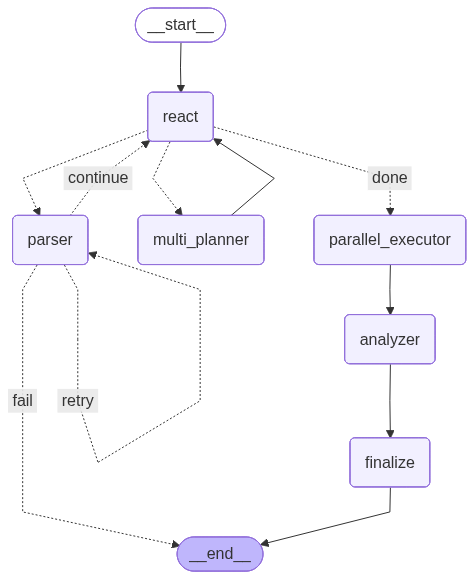

In [114]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization unavailable: {e}")
    print("\nText representation of graph:")
    print(app.get_graph().draw_ascii())

9. Main Execution Function

In [115]:
async def solve_leetcode_problem_parallel(
    problem_id: int,
    language: str = "python",
    max_retries: int = 2,
):
    """
    Run LangGraph workflow end-to-end for a single LeetCode problem (async).

    Args:
        problem_id: LeetCode problem number.
        language: Target programming language for solutions (currently used in prompts).
        max_retries: Maximum parser retries before failing.

    Returns:
        Final MultiSolutionReport object produced by the graph.
    """
    initial_state: GraphState = {
        "problem_id": problem_id,
        "language": language,
        "task": None,
        "multi_plan": None,
        "approach_results": [],
        "comparison": None,
        "final_report": None,
        "retry_count": 0,
        "max_retries": max_retries,
        "errors": [],
    }

    final_state = await app.ainvoke(initial_state)
    report = final_state.get("final_report")

    if report is None:
        raise RuntimeError("Graph finished without final_report in state")

    return report

In [116]:
from tenacity import retry, stop_after_attempt, wait_exponential

@retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=2, max=10)
)
async def invoke_llm_with_parser(chain, inputs):
    """Вызов LLM с retry"""
    return await chain.ainvoke(inputs)

10. Demo Execution

In [117]:
# Example: solve "Two Sum" problem (usually problem #1)
import nest_asyncio
nest_asyncio.apply()

report = await solve_leetcode_problem_parallel(
    problem_id=1,
    language="python",
    max_retries=2,
)

print("Title:", report.problem_title)
print("Difficulty:", report.problem_difficulty)
print("Total approaches:", report.total_approaches)
print("Successful approaches:", report.successful_approaches)
print("Recommended approach:", report.comparison.recommended_approach)

ReAct decision: call_parser - The task needs to be parsed to understand the problem requirements before planning approaches. Since task_parsed is False, the parser must be called first.
ReAct decision: plan_approaches - The problem has been parsed (task_parsed=True), but no solution plan is ready (plan_ready=False). The next logical step is to generate solution approaches for problem 1.
ReAct decision: done - The problem has been parsed and the plan is ready, so the task is completed.
==== Problem summary ====
Title: Two Sum
Difficulty: Easy
Total approaches: 2
Successful approaches: 0
Recommended approach: hash_map

==== Approaches detail ====
Approach 1: hash_map
  Planned time complexity: O(n)
  Planned space complexity: O(n)
  Score: 40.00
  Tests passed: 0/3
  Status: tests failed or not executed
  Pros:
    - Time complexity is O(n) with a single pass through the array
    - Efficient for large datasets due to constant-time lookups
  Cons:
    - Requires O(n) additional space for